<a href="https://colab.research.google.com/github/andreaps96/CIFAR10-model/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision import datasets
from torchinfo import summary
from early_stopping_pytorch import EarlyStopping
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.metrics import confusion_matrix, classification_report

from collections import Counter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
transform_tmp = T.ToTensor()

train_tmp = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform_tmp
)

test_tmp = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform_tmp
)

100%|██████████| 170M/170M [00:17<00:00, 9.87MB/s]


In [6]:
loader_tmp = DataLoader(train_tmp,batch_size=128)

mean = 0.0
std = 0.0
total_imgs = 0

for img,_ in tqdm(loader_tmp,desc="Calcolo media e std"):
    mean += torch.mean(img,[0,2,3])
    std  += torch.std(img,[0,2,3])
    total_imgs += 1

mean /= total_imgs
std /= total_imgs

print(f"\nMedia: {mean}, std: {std}")

Calcolo media e std: 100%|██████████| 391/391 [00:06<00:00, 59.95it/s]


Media: tensor([0.4914, 0.4822, 0.4465]), std: tensor([0.2467, 0.2432, 0.2612])


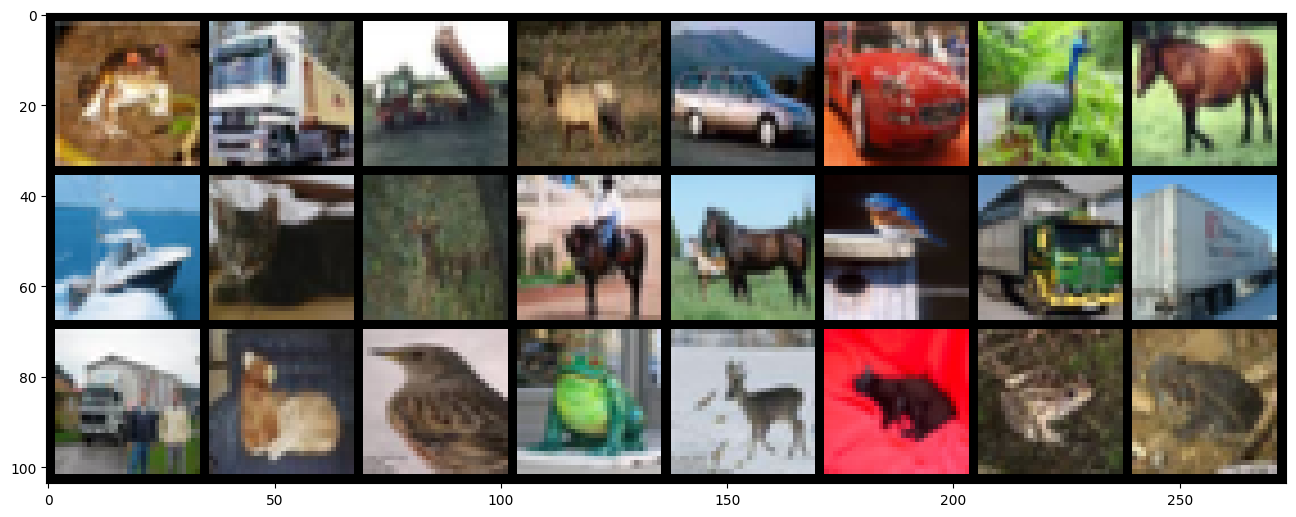

In [7]:
samples,labels = next(iter(loader_tmp))
plt.figure(figsize=(16,24))

grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

plt.imshow(np.transpose(grid_imgs,(1,2,0)))
plt.show()

airplane: 5000 immagini
automobile: 5000 immagini
bird: 5000 immagini
cat: 5000 immagini
deer: 5000 immagini
dog: 5000 immagini
frog: 5000 immagini
horse: 5000 immagini
ship: 5000 immagini
truck: 5000 immagini


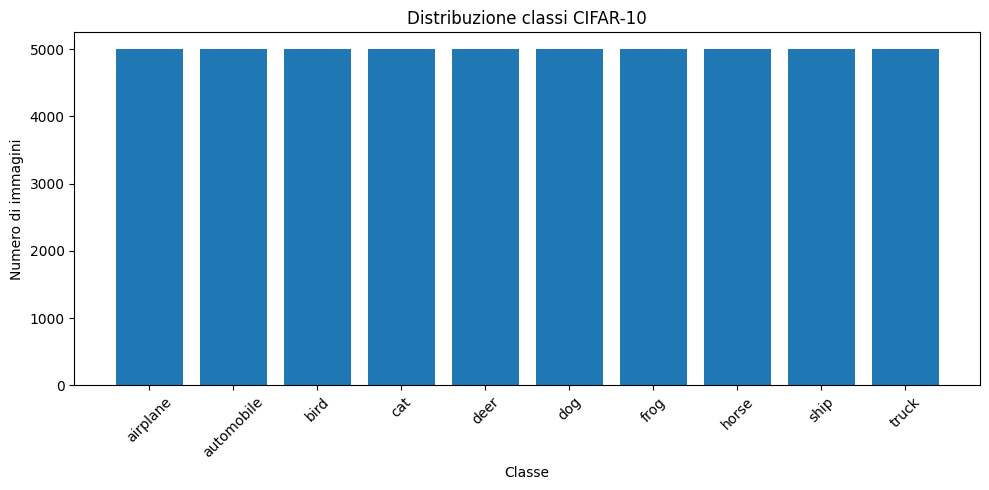

In [8]:
# Conta le classi nel training set
train_labels = [label for _, label in train_tmp]
class_counts = Counter(train_labels)

# Nomi classi CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Stampa conteggi
for i, name in enumerate(class_names):
    print(f'{name}: {class_counts[i]} immagini')

# Plot
plt.figure(figsize=(10, 5))
plt.bar(class_names, [class_counts[i] for i in range(10)])
plt.xlabel('Classe')
plt.ylabel('Numero di immagini')
plt.title('Distribuzione classi CIFAR-10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
transforms = {
    "train": T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean, std),
        # CutOut implementato con RandomErasing
        T.RandomErasing(p=0.25, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    ]),
    "test": T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
}

In [10]:
train_set = datasets.CIFAR10(
    root="./data",
    download=False,
    train=True,
    transform=transforms["train"]
)

test_set = datasets.CIFAR10(
    root="./data",
    download=False,
    train=False,
    transform=transforms["test"]
)

val_size = 0.15
train_size = train_set.__len__()
index = list(range(train_size))
np.random.shuffle(index)

split = int(np.floor(val_size * train_size))
train_idx,val_idx = index[split:],index[:split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(
    train_set,
    128,
    sampler=train_sampler,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    train_set,
    128,
    sampler=val_sampler,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_set,
    128,
    num_workers=2,
    pin_memory=True
)

In [11]:
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device)

summary(
    model,
    input_size=(1, 3, 32, 32),
    col_names=["input_size", "output_size", "kernel_size", "num_params",]
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 198MB/s]


Layer (type:depth-idx)                   Input Shape               Output Shape              Kernel Shape              Param #
ResNet                                   [1, 3, 32, 32]            [1, 1000]                 --                        --
├─Conv2d: 1-1                            [1, 3, 32, 32]            [1, 64, 16, 16]           [7, 7]                    9,408
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]           [1, 64, 16, 16]           --                        128
├─ReLU: 1-3                              [1, 64, 16, 16]           [1, 64, 16, 16]           --                        --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           [1, 64, 8, 8]             3                         --
├─Sequential: 1-5                        [1, 64, 8, 8]             [1, 64, 8, 8]             --                        --
│    └─BasicBlock: 2-1                   [1, 64, 8, 8]             [1, 64, 8, 8]             --                        --
│    │    └─Con

In [12]:
model.conv1 = nn.Conv2d(3,64,3,1,1,bias=False)

model.maxpool = nn.Identity()

model.fc = nn.Sequential(
    nn.Dropout(0.2),
    # nn.Linear(512,256),
    # nn.BatchNorm1d(256),
    # nn.ReLU(),
    nn.Linear(512,10)
)

summary(
    model,
    input_size=(1, 3, 32, 32),
    col_names=["input_size", "output_size", "kernel_size", "num_params",]
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Kernel Shape              Param #
ResNet                                   [1, 3, 32, 32]            [1, 10]                   --                        --
├─Conv2d: 1-1                            [1, 3, 32, 32]            [1, 64, 32, 32]           [3, 3]                    1,728
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           [1, 64, 32, 32]           --                        128
├─ReLU: 1-3                              [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
├─Identity: 1-4                          [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
├─Sequential: 1-5                        [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    └─BasicBlock: 2-1                   [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    │    └─Con

In [13]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

def train_epoch(model, loader, criterion, optimizer, scheduler=None):
    """
    Training epoch con supporto per EMA e gradient clipping.

    Args:
        model: Modello da addestrare
        loader: DataLoader per training
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler (opzionale)
        scheduler_per_batch: Se True, fa step dello scheduler ad ogni batch
        ema: ModelEMA object per exponential moving average (opzionale)
        max_grad_norm: Valore massimo per gradient clipping
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimizer step
        optimizer.step()

        if scheduler:
          scheduler.step()

        # Metriche
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy


def test_epoch(model, loader, criterion):
    """
    Validation/Test epoch.

    Args:
        model: Modello da valutare (può essere model originale o ema.ema)
        loader: DataLoader per validation/test
        criterion: Loss function
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Metriche
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

In [14]:
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

optimizer_1 = optim.SGD(
    model.fc.parameters(),
    lr=0.01,  # LR sicuro per SGD
    momentum=0.9,
    weight_decay=5e-4
)

epoche_fase_1 = 8

train_losses_p1, train_accs_p1 = [], []
val_losses_p1, val_accs_p1 = [], []

for epoch in range(epoche_fase_1):
    print(f"Epoca {epoch+1}/{epoche_fase_1}")
    train_loss,train_accuracy = train_epoch(model, train_loader, criterion, optimizer_1)
    val_loss, val_accuracy = test_epoch(model,val_loader,criterion)

    train_losses_p1.append(train_loss)
    train_accs_p1.append(train_accuracy)
    val_losses_p1.append(val_loss)
    val_accs_p1.append(val_accuracy)
    current_lr = optimizer_1.param_groups[0]['lr']

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | '
          f'Test Loss: {val_loss:.4f}, Test Acc: {val_accuracy:.2f}% | '
          f'LR: {current_lr:.2e}')
    print("\n")

Epoca 1/8


Train Loss: 1.9691, Train Acc: 33.44% | Test Loss: 1.7982, Test Acc: 41.16% | LR: 1.00e-02


Epoca 2/8


Train Loss: 1.8545, Train Acc: 38.83% | Test Loss: 1.7658, Test Acc: 42.45% | LR: 1.00e-02


Epoca 3/8


Train Loss: 1.8501, Train Acc: 39.25% | Test Loss: 1.8110, Test Acc: 40.75% | LR: 1.00e-02


Epoca 4/8


Train Loss: 1.8436, Train Acc: 39.55% | Test Loss: 1.7642, Test Acc: 42.17% | LR: 1.00e-02


Epoca 5/8


Train Loss: 1.8421, Train Acc: 39.62% | Test Loss: 1.7924, Test Acc: 41.63% | LR: 1.00e-02


Epoca 6/8


Train Loss: 1.8434, Train Acc: 39.67% | Test Loss: 1.7639, Test Acc: 43.13% | LR: 1.00e-02


Epoca 7/8


Train Loss: 1.8512, Train Acc: 39.45% | Test Loss: 1.7673, Test Acc: 42.24% | LR: 1.00e-02


Epoca 8/8


Train Loss: 1.8468, Train Acc: 39.48% | Test Loss: 1.7830, Test Acc: 40.75% | LR: 1.00e-02




In [15]:
for param in model.parameters():
    param.requires_grad = True

params_backbone = [p for n, p in model.named_parameters() if 'fc' not in n]
params_head = list(model.fc.parameters())

# SGD con momentum: più stabile di AdamW per fine-tuning
optimizer_p2 = optim.SGD([
    {'params': params_backbone, 'lr': 0.001},  # 10x più basso del head
    {'params': params_head, 'lr': 0.01}
], momentum=0.9, weight_decay=5e-4)

# Cosine Annealing: decadimento smooth senza picchi
epochs_p2 = 100
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_p2,
    T_max=epochs_p2,
    eta_min=1e-6
)

train_losses_p2, train_accs_p2 = [], []
val_losses_p2, val_accs_p2 = [], []

best_val_acc = 0.0
patience = 15  # Più pazienza per non fermarsi troppo presto
patience_counter = 0
best_epoch = 0

early_stoppinng = EarlyStopping(patience=patience, verbose=True,path="prova_cifar.pt")

In [16]:
for epoch in range(epochs_p2):
    print(f"Epoch {epoch+1}/{epochs_p2}")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer_p2)
    val_loss, val_acc = test_epoch(model, val_loader, criterion)

    train_losses_p2.append(train_loss)
    train_accs_p2.append(train_acc)
    val_losses_p2.append(val_loss)
    val_accs_p2.append(val_acc)

    # Step dello scheduler DOPO la validation
    scheduler.step()

    current_lr_backbone = optimizer_p2.param_groups[0]['lr']
    current_lr_head = optimizer_p2.param_groups[1]['lr']

    print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.2f}% | "
          f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.2f}% | "
          f"LR: {current_lr_backbone:.2e}/{current_lr_head:.2e}")

    early_stoppinng(val_loss, model)

    if early_stoppinng.early_stop:
        print("Early stopping attivato")
        break

    print("\n")

Epoch 1/100


Train loss: 1.7025, Train accuracy: 45.98% | Validation loss: 1.5319, Validation accuracy: 53.35% | LR: 1.00e-03/1.00e-02
Validation loss decreased (inf --> 1.531864).  Saving model ...


Epoch 2/100


Train loss: 1.5293, Train accuracy: 54.36% | Validation loss: 1.4033, Validation accuracy: 59.97% | LR: 9.99e-04/9.99e-03
Validation loss decreased (1.531864 --> 1.403347).  Saving model ...


Epoch 3/100


Train loss: 1.3922, Train accuracy: 61.02% | Validation loss: 1.2843, Validation accuracy: 66.07% | LR: 9.98e-04/9.98e-03
Validation loss decreased (1.403347 --> 1.284279).  Saving model ...


Epoch 4/100


Train loss: 1.2885, Train accuracy: 65.94% | Validation loss: 1.2069, Validation accuracy: 69.67% | LR: 9.96e-04/9.96e-03
Validation loss decreased (1.284279 --> 1.206881).  Saving model ...


Epoch 5/100


Train loss: 1.2023, Train accuracy: 69.90% | Validation loss: 1.1286, Validation accuracy: 73.25% | LR: 9.94e-04/9.94e-03
Validation loss decreased (1.206881 --> 1.128575).  Saving model ...


Epoch 6/100


Train loss: 1.1318, Train accuracy: 73.59% | Validation loss: 1.0632, Validation accuracy: 75.96% | LR: 9.91e-04/9.91e-03
Validation loss decreased (1.128575 --> 1.063184).  Saving model ...


Epoch 7/100


Train loss: 1.0684, Train accuracy: 76.15% | Validation loss: 1.0167, Validation accuracy: 78.32% | LR: 9.88e-04/9.88e-03
Validation loss decreased (1.063184 --> 1.016745).  Saving model ...


Epoch 8/100


Train loss: 1.0271, Train accuracy: 77.94% | Validation loss: 0.9748, Validation accuracy: 80.47% | LR: 9.84e-04/9.84e-03
Validation loss decreased (1.016745 --> 0.974773).  Saving model ...


Epoch 9/100


Train loss: 0.9786, Train accuracy: 80.17% | Validation loss: 0.9433, Validation accuracy: 81.61% | LR: 9.80e-04/9.80e-03
Validation loss decreased (0.974773 --> 0.943304).  Saving model ...


Epoch 10/100


Train loss: 0.9443, Train accuracy: 81.58% | Validation loss: 0.9083, Validation accuracy: 83.28% | LR: 9.76e-04/9.76e-03
Validation loss decreased (0.943304 --> 0.908306).  Saving model ...


Epoch 11/100


Train loss: 0.9231, Train accuracy: 82.97% | Validation loss: 0.8885, Validation accuracy: 83.91% | LR: 9.70e-04/9.70e-03
Validation loss decreased (0.908306 --> 0.888523).  Saving model ...


Epoch 12/100


Train loss: 0.8983, Train accuracy: 84.00% | Validation loss: 0.8774, Validation accuracy: 84.65% | LR: 9.65e-04/9.65e-03
Validation loss decreased (0.888523 --> 0.877386).  Saving model ...


Epoch 13/100


Train loss: 0.8771, Train accuracy: 84.90% | Validation loss: 0.8507, Validation accuracy: 85.69% | LR: 9.59e-04/9.59e-03
Validation loss decreased (0.877386 --> 0.850714).  Saving model ...


Epoch 14/100


Train loss: 0.8567, Train accuracy: 85.67% | Validation loss: 0.8431, Validation accuracy: 86.04% | LR: 9.52e-04/9.52e-03
Validation loss decreased (0.850714 --> 0.843123).  Saving model ...


Epoch 15/100


Train loss: 0.8422, Train accuracy: 86.11% | Validation loss: 0.8294, Validation accuracy: 86.52% | LR: 9.46e-04/9.46e-03
Validation loss decreased (0.843123 --> 0.829389).  Saving model ...


Epoch 16/100


Train loss: 0.8301, Train accuracy: 86.91% | Validation loss: 0.8164, Validation accuracy: 87.09% | LR: 9.38e-04/9.38e-03
Validation loss decreased (0.829389 --> 0.816350).  Saving model ...


Epoch 17/100


Train loss: 0.8131, Train accuracy: 87.52% | Validation loss: 0.8023, Validation accuracy: 87.65% | LR: 9.30e-04/9.30e-03
Validation loss decreased (0.816350 --> 0.802264).  Saving model ...


Epoch 18/100


Train loss: 0.7994, Train accuracy: 88.11% | Validation loss: 0.7925, Validation accuracy: 87.92% | LR: 9.22e-04/9.22e-03
Validation loss decreased (0.802264 --> 0.792538).  Saving model ...


Epoch 19/100


Train loss: 0.7886, Train accuracy: 88.58% | Validation loss: 0.7912, Validation accuracy: 88.37% | LR: 9.14e-04/9.14e-03
Validation loss decreased (0.792538 --> 0.791187).  Saving model ...


Epoch 20/100


Train loss: 0.7799, Train accuracy: 88.83% | Validation loss: 0.7811, Validation accuracy: 88.48% | LR: 9.05e-04/9.05e-03
Validation loss decreased (0.791187 --> 0.781122).  Saving model ...


Epoch 21/100


Train loss: 0.7702, Train accuracy: 89.36% | Validation loss: 0.7731, Validation accuracy: 88.43% | LR: 8.95e-04/8.95e-03
Validation loss decreased (0.781122 --> 0.773060).  Saving model ...


Epoch 22/100


Train loss: 0.7620, Train accuracy: 89.86% | Validation loss: 0.7665, Validation accuracy: 89.20% | LR: 8.85e-04/8.85e-03
Validation loss decreased (0.773060 --> 0.766523).  Saving model ...


Epoch 23/100


Train loss: 0.7531, Train accuracy: 90.20% | Validation loss: 0.7584, Validation accuracy: 89.60% | LR: 8.75e-04/8.75e-03
Validation loss decreased (0.766523 --> 0.758372).  Saving model ...


Epoch 24/100


Train loss: 0.7479, Train accuracy: 90.32% | Validation loss: 0.7498, Validation accuracy: 89.92% | LR: 8.65e-04/8.64e-03
Validation loss decreased (0.758372 --> 0.749770).  Saving model ...


Epoch 25/100


Train loss: 0.7423, Train accuracy: 90.70% | Validation loss: 0.7465, Validation accuracy: 89.75% | LR: 8.54e-04/8.54e-03
Validation loss decreased (0.749770 --> 0.746517).  Saving model ...


Epoch 26/100


Train loss: 0.7328, Train accuracy: 90.90% | Validation loss: 0.7505, Validation accuracy: 89.92% | LR: 8.42e-04/8.42e-03
EarlyStopping counter: 1 out of 15


Epoch 27/100


Train loss: 0.7308, Train accuracy: 91.08% | Validation loss: 0.7373, Validation accuracy: 90.21% | LR: 8.31e-04/8.31e-03
Validation loss decreased (0.746517 --> 0.737285).  Saving model ...


Epoch 28/100


Train loss: 0.7238, Train accuracy: 91.31% | Validation loss: 0.7435, Validation accuracy: 90.00% | LR: 8.19e-04/8.19e-03
EarlyStopping counter: 1 out of 15


Epoch 29/100


Train loss: 0.7147, Train accuracy: 91.70% | Validation loss: 0.7311, Validation accuracy: 90.17% | LR: 8.07e-04/8.06e-03
Validation loss decreased (0.737285 --> 0.731051).  Saving model ...


Epoch 30/100


Train loss: 0.7124, Train accuracy: 91.98% | Validation loss: 0.7397, Validation accuracy: 90.16% | LR: 7.94e-04/7.94e-03
EarlyStopping counter: 1 out of 15


Epoch 31/100


Train loss: 0.7076, Train accuracy: 92.16% | Validation loss: 0.7369, Validation accuracy: 90.36% | LR: 7.81e-04/7.81e-03
EarlyStopping counter: 2 out of 15


Epoch 32/100


Train loss: 0.7016, Train accuracy: 92.27% | Validation loss: 0.7200, Validation accuracy: 90.97% | LR: 7.68e-04/7.68e-03
Validation loss decreased (0.731051 --> 0.720019).  Saving model ...


Epoch 33/100


Train loss: 0.6963, Train accuracy: 92.57% | Validation loss: 0.7232, Validation accuracy: 90.85% | LR: 7.55e-04/7.55e-03
EarlyStopping counter: 1 out of 15


Epoch 34/100


Train loss: 0.6925, Train accuracy: 92.67% | Validation loss: 0.7177, Validation accuracy: 91.23% | LR: 7.41e-04/7.41e-03
Validation loss decreased (0.720019 --> 0.717750).  Saving model ...


Epoch 35/100


Train loss: 0.6864, Train accuracy: 92.99% | Validation loss: 0.7163, Validation accuracy: 91.13% | LR: 7.27e-04/7.27e-03
Validation loss decreased (0.717750 --> 0.716313).  Saving model ...


Epoch 36/100


Train loss: 0.6853, Train accuracy: 93.08% | Validation loss: 0.7157, Validation accuracy: 91.25% | LR: 7.13e-04/7.13e-03
Validation loss decreased (0.716313 --> 0.715691).  Saving model ...


Epoch 37/100


Train loss: 0.6813, Train accuracy: 93.28% | Validation loss: 0.7066, Validation accuracy: 91.72% | LR: 6.99e-04/6.99e-03
Validation loss decreased (0.715691 --> 0.706631).  Saving model ...


Epoch 38/100


Train loss: 0.6785, Train accuracy: 93.18% | Validation loss: 0.7081, Validation accuracy: 91.32% | LR: 6.84e-04/6.84e-03
EarlyStopping counter: 1 out of 15


Epoch 39/100


Train loss: 0.6772, Train accuracy: 93.61% | Validation loss: 0.7106, Validation accuracy: 91.23% | LR: 6.70e-04/6.69e-03
EarlyStopping counter: 2 out of 15


Epoch 40/100


Train loss: 0.6690, Train accuracy: 93.65% | Validation loss: 0.7070, Validation accuracy: 91.35% | LR: 6.55e-04/6.55e-03
EarlyStopping counter: 3 out of 15


Epoch 41/100


Train loss: 0.6702, Train accuracy: 93.80% | Validation loss: 0.7036, Validation accuracy: 91.49% | LR: 6.40e-04/6.40e-03
Validation loss decreased (0.706631 --> 0.703561).  Saving model ...


Epoch 42/100


Train loss: 0.6636, Train accuracy: 94.01% | Validation loss: 0.7060, Validation accuracy: 91.57% | LR: 6.25e-04/6.24e-03
EarlyStopping counter: 1 out of 15


Epoch 43/100


Train loss: 0.6623, Train accuracy: 94.03% | Validation loss: 0.7038, Validation accuracy: 91.59% | LR: 6.09e-04/6.09e-03
EarlyStopping counter: 2 out of 15


Epoch 44/100


Train loss: 0.6592, Train accuracy: 94.18% | Validation loss: 0.6989, Validation accuracy: 91.71% | LR: 5.94e-04/5.94e-03
Validation loss decreased (0.703561 --> 0.698933).  Saving model ...


Epoch 45/100


Train loss: 0.6602, Train accuracy: 94.14% | Validation loss: 0.6970, Validation accuracy: 91.96% | LR: 5.79e-04/5.78e-03
Validation loss decreased (0.698933 --> 0.697005).  Saving model ...


Epoch 46/100


Train loss: 0.6561, Train accuracy: 94.23% | Validation loss: 0.6993, Validation accuracy: 91.84% | LR: 5.63e-04/5.63e-03
EarlyStopping counter: 1 out of 15


Epoch 47/100


Train loss: 0.6517, Train accuracy: 94.64% | Validation loss: 0.6942, Validation accuracy: 91.96% | LR: 5.48e-04/5.47e-03
Validation loss decreased (0.697005 --> 0.694242).  Saving model ...


Epoch 48/100


Train loss: 0.6487, Train accuracy: 94.48% | Validation loss: 0.6916, Validation accuracy: 92.08% | LR: 5.32e-04/5.31e-03
Validation loss decreased (0.694242 --> 0.691642).  Saving model ...


Epoch 49/100


Train loss: 0.6493, Train accuracy: 94.60% | Validation loss: 0.6906, Validation accuracy: 92.05% | LR: 5.16e-04/5.16e-03
Validation loss decreased (0.691642 --> 0.690599).  Saving model ...


Epoch 50/100


Train loss: 0.6455, Train accuracy: 94.79% | Validation loss: 0.6887, Validation accuracy: 92.24% | LR: 5.01e-04/5.00e-03
Validation loss decreased (0.690599 --> 0.688684).  Saving model ...


Epoch 51/100


Train loss: 0.6488, Train accuracy: 94.69% | Validation loss: 0.6890, Validation accuracy: 92.13% | LR: 4.85e-04/4.84e-03
EarlyStopping counter: 1 out of 15


Epoch 52/100


Train loss: 0.6403, Train accuracy: 94.82% | Validation loss: 0.6862, Validation accuracy: 92.19% | LR: 4.69e-04/4.69e-03
Validation loss decreased (0.688684 --> 0.686161).  Saving model ...


Epoch 53/100


Train loss: 0.6415, Train accuracy: 94.89% | Validation loss: 0.6943, Validation accuracy: 92.08% | LR: 4.53e-04/4.53e-03
EarlyStopping counter: 1 out of 15


Epoch 54/100


Train loss: 0.6393, Train accuracy: 95.04% | Validation loss: 0.6890, Validation accuracy: 92.00% | LR: 4.38e-04/4.37e-03
EarlyStopping counter: 2 out of 15


Epoch 55/100


Train loss: 0.6371, Train accuracy: 95.06% | Validation loss: 0.6896, Validation accuracy: 92.01% | LR: 4.22e-04/4.22e-03
EarlyStopping counter: 3 out of 15


Epoch 56/100


Train loss: 0.6354, Train accuracy: 95.31% | Validation loss: 0.6848, Validation accuracy: 92.39% | LR: 4.07e-04/4.06e-03
Validation loss decreased (0.686161 --> 0.684807).  Saving model ...


Epoch 57/100


Train loss: 0.6367, Train accuracy: 95.15% | Validation loss: 0.6806, Validation accuracy: 92.61% | LR: 3.92e-04/3.91e-03
Validation loss decreased (0.684807 --> 0.680637).  Saving model ...


Epoch 58/100


Train loss: 0.6307, Train accuracy: 95.39% | Validation loss: 0.6765, Validation accuracy: 92.64% | LR: 3.76e-04/3.76e-03
Validation loss decreased (0.680637 --> 0.676520).  Saving model ...


Epoch 59/100


Train loss: 0.6310, Train accuracy: 95.33% | Validation loss: 0.6795, Validation accuracy: 92.52% | LR: 3.61e-04/3.61e-03
EarlyStopping counter: 1 out of 15


Epoch 60/100


Train loss: 0.6339, Train accuracy: 95.20% | Validation loss: 0.6801, Validation accuracy: 92.63% | LR: 3.46e-04/3.46e-03
EarlyStopping counter: 2 out of 15


Epoch 61/100


Train loss: 0.6286, Train accuracy: 95.52% | Validation loss: 0.6847, Validation accuracy: 92.31% | LR: 3.31e-04/3.31e-03
EarlyStopping counter: 3 out of 15


Epoch 62/100


Train loss: 0.6274, Train accuracy: 95.46% | Validation loss: 0.6790, Validation accuracy: 92.67% | LR: 3.17e-04/3.16e-03
EarlyStopping counter: 4 out of 15


Epoch 63/100


Train loss: 0.6260, Train accuracy: 95.56% | Validation loss: 0.6853, Validation accuracy: 92.37% | LR: 3.02e-04/3.01e-03
EarlyStopping counter: 5 out of 15


Epoch 64/100


Train loss: 0.6284, Train accuracy: 95.38% | Validation loss: 0.6818, Validation accuracy: 92.51% | LR: 2.88e-04/2.87e-03
EarlyStopping counter: 6 out of 15


Epoch 65/100


Train loss: 0.6244, Train accuracy: 95.66% | Validation loss: 0.6767, Validation accuracy: 92.63% | LR: 2.74e-04/2.73e-03
EarlyStopping counter: 7 out of 15


Epoch 66/100


Train loss: 0.6254, Train accuracy: 95.54% | Validation loss: 0.6757, Validation accuracy: 92.89% | LR: 2.60e-04/2.59e-03
Validation loss decreased (0.676520 --> 0.675746).  Saving model ...


Epoch 67/100


Train loss: 0.6228, Train accuracy: 95.60% | Validation loss: 0.6796, Validation accuracy: 92.64% | LR: 2.46e-04/2.46e-03
EarlyStopping counter: 1 out of 15


Epoch 68/100


Train loss: 0.6243, Train accuracy: 95.60% | Validation loss: 0.6789, Validation accuracy: 92.44% | LR: 2.33e-04/2.32e-03
EarlyStopping counter: 2 out of 15


Epoch 69/100


Train loss: 0.6211, Train accuracy: 95.75% | Validation loss: 0.6795, Validation accuracy: 92.72% | LR: 2.20e-04/2.19e-03
EarlyStopping counter: 3 out of 15


Epoch 70/100


Train loss: 0.6210, Train accuracy: 95.76% | Validation loss: 0.6786, Validation accuracy: 92.67% | LR: 2.07e-04/2.06e-03
EarlyStopping counter: 4 out of 15


Epoch 71/100


Train loss: 0.6220, Train accuracy: 95.69% | Validation loss: 0.6740, Validation accuracy: 92.43% | LR: 1.94e-04/1.94e-03
Validation loss decreased (0.675746 --> 0.673988).  Saving model ...


Epoch 72/100


Train loss: 0.6212, Train accuracy: 95.81% | Validation loss: 0.6765, Validation accuracy: 92.87% | LR: 1.82e-04/1.81e-03
EarlyStopping counter: 1 out of 15


Epoch 73/100


Train loss: 0.6170, Train accuracy: 95.90% | Validation loss: 0.6780, Validation accuracy: 92.84% | LR: 1.70e-04/1.69e-03
EarlyStopping counter: 2 out of 15


Epoch 74/100


Train loss: 0.6161, Train accuracy: 95.99% | Validation loss: 0.6844, Validation accuracy: 92.11% | LR: 1.59e-04/1.58e-03
EarlyStopping counter: 3 out of 15


Epoch 75/100


Train loss: 0.6181, Train accuracy: 95.89% | Validation loss: 0.6711, Validation accuracy: 92.85% | LR: 1.47e-04/1.47e-03
Validation loss decreased (0.673988 --> 0.671098).  Saving model ...


Epoch 76/100


Train loss: 0.6161, Train accuracy: 95.93% | Validation loss: 0.6700, Validation accuracy: 92.87% | LR: 1.36e-04/1.36e-03
Validation loss decreased (0.671098 --> 0.669974).  Saving model ...


Epoch 77/100


Train loss: 0.6167, Train accuracy: 95.97% | Validation loss: 0.6730, Validation accuracy: 93.00% | LR: 1.26e-04/1.25e-03
EarlyStopping counter: 1 out of 15


Epoch 78/100


Train loss: 0.6163, Train accuracy: 95.99% | Validation loss: 0.6706, Validation accuracy: 93.21% | LR: 1.16e-04/1.15e-03
EarlyStopping counter: 2 out of 15


Epoch 79/100


Train loss: 0.6145, Train accuracy: 96.11% | Validation loss: 0.6748, Validation accuracy: 92.92% | LR: 1.06e-04/1.05e-03
EarlyStopping counter: 3 out of 15


Epoch 80/100


Train loss: 0.6148, Train accuracy: 95.99% | Validation loss: 0.6712, Validation accuracy: 93.09% | LR: 9.64e-05/9.56e-04
EarlyStopping counter: 4 out of 15


Epoch 81/100


Train loss: 0.6148, Train accuracy: 96.00% | Validation loss: 0.6677, Validation accuracy: 93.04% | LR: 8.74e-05/8.66e-04
Validation loss decreased (0.669974 --> 0.667705).  Saving model ...


Epoch 82/100


Train loss: 0.6171, Train accuracy: 96.00% | Validation loss: 0.6782, Validation accuracy: 92.71% | LR: 7.88e-05/7.79e-04
EarlyStopping counter: 1 out of 15


Epoch 83/100


Train loss: 0.6199, Train accuracy: 95.85% | Validation loss: 0.6681, Validation accuracy: 92.91% | LR: 7.06e-05/6.97e-04
EarlyStopping counter: 2 out of 15


Epoch 84/100


Train loss: 0.6107, Train accuracy: 96.09% | Validation loss: 0.6720, Validation accuracy: 92.92% | LR: 6.28e-05/6.19e-04
EarlyStopping counter: 3 out of 15


Epoch 85/100


Train loss: 0.6129, Train accuracy: 96.08% | Validation loss: 0.6800, Validation accuracy: 92.55% | LR: 5.54e-05/5.46e-04
EarlyStopping counter: 4 out of 15


Epoch 86/100


Train loss: 0.6157, Train accuracy: 95.99% | Validation loss: 0.6717, Validation accuracy: 93.03% | LR: 4.85e-05/4.77e-04
EarlyStopping counter: 5 out of 15


Epoch 87/100


Train loss: 0.6151, Train accuracy: 95.92% | Validation loss: 0.6713, Validation accuracy: 92.93% | LR: 4.21e-05/4.12e-04
EarlyStopping counter: 6 out of 15


Epoch 88/100


Train loss: 0.6110, Train accuracy: 96.18% | Validation loss: 0.6698, Validation accuracy: 92.97% | LR: 3.61e-05/3.52e-04
EarlyStopping counter: 7 out of 15


Epoch 89/100


Train loss: 0.6126, Train accuracy: 96.18% | Validation loss: 0.6734, Validation accuracy: 92.87% | LR: 3.05e-05/2.97e-04
EarlyStopping counter: 8 out of 15


Epoch 90/100


Train loss: 0.6113, Train accuracy: 96.14% | Validation loss: 0.6702, Validation accuracy: 92.93% | LR: 2.54e-05/2.46e-04
EarlyStopping counter: 9 out of 15


Epoch 91/100


Train loss: 0.6107, Train accuracy: 96.19% | Validation loss: 0.6710, Validation accuracy: 93.29% | LR: 2.08e-05/2.00e-04
EarlyStopping counter: 10 out of 15


Epoch 92/100


Train loss: 0.6139, Train accuracy: 95.99% | Validation loss: 0.6759, Validation accuracy: 92.81% | LR: 1.67e-05/1.58e-04
EarlyStopping counter: 11 out of 15


Epoch 93/100


Train loss: 0.6156, Train accuracy: 96.06% | Validation loss: 0.6761, Validation accuracy: 92.84% | LR: 1.30e-05/1.21e-04
EarlyStopping counter: 12 out of 15


Epoch 94/100


Train loss: 0.6108, Train accuracy: 96.16% | Validation loss: 0.6787, Validation accuracy: 92.83% | LR: 9.85e-06/8.96e-05
EarlyStopping counter: 13 out of 15


Epoch 95/100


Train loss: 0.6165, Train accuracy: 95.98% | Validation loss: 0.6793, Validation accuracy: 92.63% | LR: 7.15e-06/6.26e-05
EarlyStopping counter: 14 out of 15


Epoch 96/100


Train loss: 0.6107, Train accuracy: 96.22% | Validation loss: 0.6783, Validation accuracy: 92.56% | LR: 4.94e-06/4.04e-05
EarlyStopping counter: 15 out of 15
Early stopping attivato


In [18]:
all_preds = []
all_labels = []
test_loss = 0.0
correct_preds = 0
total_samples = 0

model.eval()
with torch.no_grad():
  for inputs,labels in tqdm(test_loader,desc="Test"):
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)

    loss = criterion(outputs,labels)
    test_loss += loss.item()

    _,predicted = outputs.max(1)
    total_samples += labels.size(0)

    correct_preds += (predicted == labels).sum().item()
    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
accuracy = 100.0 * correct_preds / total_samples
all_preds_np = np.array(all_preds)
all_labels_np = np.array(all_labels)

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print("\nclassification report")
print(f"{classification_report(all_labels_np,all_preds_np)}")
print("\n")

Test: 100%|██████████| 79/79 [00:01<00:00, 64.83it/s]


Test Loss: 0.6457
Test Accuracy: 94.2100

classification report
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1000
           1       0.96      0.97      0.97      1000
           2       0.95      0.91      0.93      1000
           3       0.88      0.88      0.88      1000
           4       0.94      0.95      0.94      1000
           5       0.91      0.90      0.90      1000
           6       0.96      0.97      0.97      1000
           7       0.96      0.96      0.96      1000
           8       0.96      0.97      0.96      1000
           9       0.96      0.95      0.95      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000





Confusion matrix


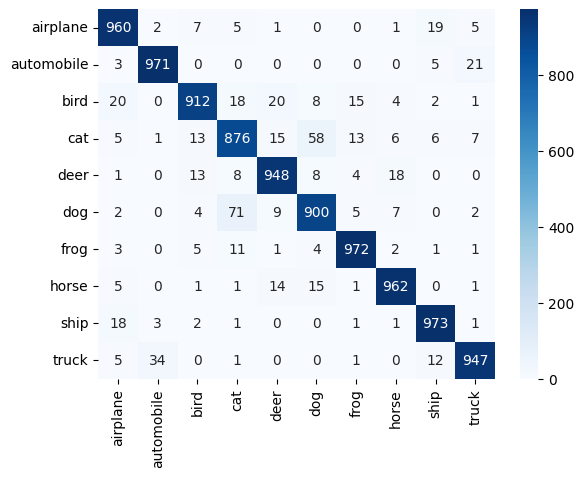

In [19]:
print("Confusion matrix")
cm = confusion_matrix(all_labels_np,all_preds_np)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.show()